In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

In [8]:
X_meta = np.load("../processed/X_metadata.npy")
y_privacy = np.load("../processed/y_privacy.npy")
y_categories = np.load("../processed/y_categories.npy")
y_types = np.load("../processed/y_types.npy")

# Use ground-truth Step 1 predictions here for now
X_combined = np.concatenate([X_meta, y_privacy, y_categories], axis=1)
print("Combined input shape:", X_combined.shape)  # Should be (10000, 82)


Combined input shape: (10000, 82)


In [9]:
X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(y_types, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)


In [10]:
class DataTypePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=34):
        super(DataTypePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [11]:
model = DataTypePredictor(input_dim=X_combined.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

f1_scores = []

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            probs = torch.sigmoid(model(xb))
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_true.append(yb.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    f1 = f1_score(all_true, all_preds, average="micro")
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}: F1 Score = {f1:.4f}")


Epoch 1: F1 Score = 0.6881
Epoch 2: F1 Score = 0.7563
Epoch 3: F1 Score = 0.7881
Epoch 4: F1 Score = 0.8088
Epoch 5: F1 Score = 0.8161
Epoch 6: F1 Score = 0.8285
Epoch 7: F1 Score = 0.8311
Epoch 8: F1 Score = 0.8326
Epoch 9: F1 Score = 0.8363
Epoch 10: F1 Score = 0.8390
Epoch 11: F1 Score = 0.8420
Epoch 12: F1 Score = 0.8430
Epoch 13: F1 Score = 0.8436
Epoch 14: F1 Score = 0.8439
Epoch 15: F1 Score = 0.8451
Epoch 16: F1 Score = 0.8456
Epoch 17: F1 Score = 0.8486
Epoch 18: F1 Score = 0.8461
Epoch 19: F1 Score = 0.8488
Epoch 20: F1 Score = 0.8470
Epoch 21: F1 Score = 0.8450
Epoch 22: F1 Score = 0.8480
Epoch 23: F1 Score = 0.8461
Epoch 24: F1 Score = 0.8488
Epoch 25: F1 Score = 0.8479
Epoch 26: F1 Score = 0.8486
Epoch 27: F1 Score = 0.8484
Epoch 28: F1 Score = 0.8483
Epoch 29: F1 Score = 0.8469
Epoch 30: F1 Score = 0.8470
Epoch 31: F1 Score = 0.8479
Epoch 32: F1 Score = 0.8471
Epoch 33: F1 Score = 0.8467
Epoch 34: F1 Score = 0.8478
Epoch 35: F1 Score = 0.8484
Epoch 36: F1 Score = 0.8496
E

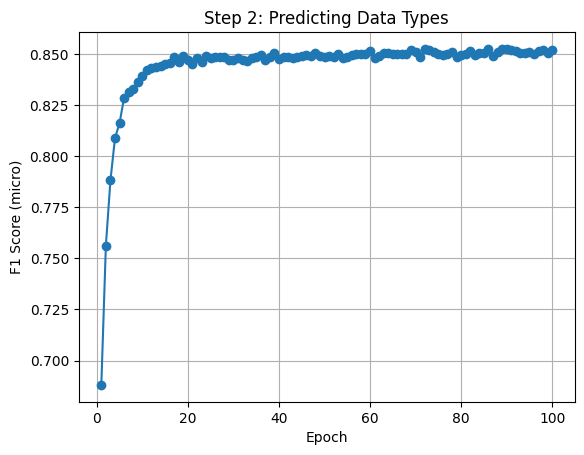

In [12]:
plt.plot(range(1, len(f1_scores)+1), f1_scores, marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (micro)")
plt.title("Step 2: Predicting Data Types")
plt.grid(True)
plt.show()


In [13]:
from sklearn.metrics import classification_report

import pickle
with open("../processed/mlb_types.pkl", "rb") as f:
    mlb_privacy = pickle.load(f)

print(classification_report(
    all_true, all_preds, 
    target_names=mlb_privacy.classes_,
    zero_division=0
))

                         precision    recall  f1-score   support

       Advertising Data       0.75      0.79      0.77       594
             Audio Data       0.58      0.08      0.13        92
       Browsing History       1.00      1.00      1.00        38
        Coarse Location       0.85      0.96      0.91       534
               Contacts       1.00      1.00      1.00        75
             Crash Data       0.96      1.00      0.98      1168
            Credit Info       1.00      0.06      0.12        16
       Customer Support       0.72      0.88      0.79       385
              Device ID       0.88      0.99      0.93       988
          Email Address       0.95      1.00      0.97       601
Emails or Text Messages       1.00      0.11      0.19        57
   Environment Scanning       0.00      0.00      0.00         1
                Fitness       0.63      0.69      0.66        32
       Gameplay Content       0.53      0.32      0.40        97
                  Hands 